In [5]:
import tensorflow as tf 
import tensorflow_hub as hub 
from tensorflow.keras import layers 
import bert 
import re 
# re — Regular expression operations
import math
import csv
import pandas as pd                     
import cv2 as cv 
from PIL import Image, ImageSequence
from tensorflow.keras import losses
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sys
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import requests
# Requests is an elegant and simple HTTP library for Python
import os 
# os — Miscellaneous operating system interfaces
import text2emotion as te
import textstat as ts

In [2]:
!pip install bert-for-tf2 sentencepiece textstat text2emotion

     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 1.2MB 8.6MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 1.9MB 39.7MB/s 
     |████████████████████████████████| 133kB 36.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=a99aa355639584f61d695d10a185056ad5f8826753f5e804586ce742395bf54d
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=7322d85924590909e328624503d8a226dc0b10156502479ac4a42d540aab1540
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=269d7ed7a7c420b01442b012c958f8441bebc77

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initial Settings


In [7]:
os.chdir('/content/drive/Shareddrives/Animated Gif/GIF models/redditgif')
!pwd

/content/drive/Shareddrives/Animated Gif/GIF models/redditgif


In [15]:
data = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/redditgif/reddit_data_brightness")
data.isnull().values.any()
gif_file = data['filenames']
raw_reddit = data['title']
data.shape

(5744, 8)

In [16]:
NUM_OF_GIF = len(data)
NUM_OF_GIF
gif_file
# raw_text

0       mt0nqt.gif
1       msz066.gif
2       msyt6a.gif
3       msy15j.gif
4       mssnzt.gif
           ...    
5739    2r91p9.gif
5740    2r8ynj.gif
5741    2r8x12.gif
5742    2r8uwx.gif
5743    2r8uhu.gif
Name: filenames, Length: 5744, dtype: object

# Tweet Pre-Process 

## Remove Special Char

In [13]:
# definition for function for removing html tags 
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [14]:
# definition for function for remove any punctuations and special characters
def preprocess_text(raw_tweet):
    # Removing html tags
    sentence = remove_tags(raw_tweet)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [18]:
# run the preprocess_text function to clean tweets list 
reddits = [] 
for reddit in raw_reddit[:NUM_OF_GIF]:
    reddits.append(preprocess_text(reddit))

## Tokenizing 

In [19]:
# Create a tokenizer 
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# .numpy(): converts a tensor object into an numpy.ndarray
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [20]:
# Definition for function for convert tweet to ids 
def tokenize_tweets(text_tweets):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_tweets))

In [21]:
# run the tokenize_tweets on tweets 
tokenized_reddits = [tokenize_tweets(reddit) for reddit in reddits]

# GIF Pre-Process

## Sentiment Feature Process

In [29]:
sarcasticModel = keras.models.load_model('/content/drive/MyDrive/AwesomeGif/sarcasmModel.h5')
sentimentModel = keras.models.load_model('/content/drive/MyDrive/AwesomeGif/sentimentModel.h5')

In [22]:
#Creating Tokenizers
#Sarcasm
sarcasmDF = pd.read_csv("/content/drive/MyDrive/AwesomeGif/Clean_Sarcasm_Reddit.csv")
for idx,row in sarcasmDF.iterrows():
    row[1] = row[1].replace('rt',' ')
    
max_words = 2000
sarcasticTokenizer = Tokenizer(num_words=max_words, split=' ')
sarcasticTokenizer.fit_on_texts(sarcasmDF['headline'].values)
#Sentiment 
sentimentDF = pd.read_csv("/content/drive/MyDrive/AwesomeGif/Twitter_Data_2.csv")
max_words = 5000
max_len=50
sentimentTokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
sentimentTokenizer.fit_on_texts(sentimentDF['clean_text'])

In [23]:
def predictSentiment(text):
  '''Function to predict sentiment class of the passed text'''
    
  sentimentClasses = ['Negative', 'Neutral', 'Positive']
  max_len=50
    
  # Transforms text to a sequence of integers using a tokenizer object
  xt = sentimentTokenizer.texts_to_sequences(text)
  # Pad sequences to the same length
  xt = pad_sequences(xt, padding='post', maxlen=max_len)
  # Do the prediction using the loaded model
  yt = sentimentModel.predict(xt).argmax(axis=1)
  # Print the predicted sentiment

  return sentimentClasses[yt[0]]  

In [24]:
def predictSarcasm(text):
  '''Function to predict sarcasm class of the passed text'''
    
  sarcasticClasses = ['Not-Sarcastic', 'Sarcastic']
  max_len=50
    
  # Transforms text to a sequence of integers using a tokenizer object
  xt = sarcasticTokenizer.texts_to_sequences(text)
  #print(xt)
  # Pad sequences to the same length
  xt = pad_sequences(xt, padding='post', maxlen=max_len)
  # Do the prediction using the loaded model
  #print(xt)
  yt = sarcasticModel.predict(xt).argmax(axis=1)
  # Print the predicted sentiment
  return sarcasticClasses[yt[0]] 

In [25]:
def convertTextToEmotions(text):
    return te.get_emotion(text)

In [26]:
def convertTextToStats(text):
  # get the text for the row and create the scores 
  readingEase = ts.flesch_reading_ease(text)
  dcScore = ts.dale_chall_readability_score(text)
  lFormula = ts.linsear_write_formula(text)
  return {"Reading Ease": readingEase, "Dale-Chall": dcScore, "Linsear Write": lFormula}

In [27]:
def extractTextFeatures(text):
  # Emotions dictionary
  emotions = convertTextToEmotions(text)
  # Stat dicitonary
  stats = convertTextToStats(text)
  # ML dictinoary 
  ml = {"Sarcasm Indicator": predictSarcasm([text]), "Sentiment": predictSentiment([text])} 
  return {**emotions,  **stats, **ml}

In [30]:
extractTextFeatures("I want to go on a walk today with my friends")

{'Angry': 0.0,
 'Dale-Chall': 0.55,
 'Fear': 0.0,
 'Happy': 1.0,
 'Linsear Write': 4.5,
 'Reading Ease': 102.61,
 'Sad': 0.0,
 'Sarcasm Indicator': 'Sarcastic',
 'Sentiment': 'Neutral',
 'Surprise': 0.0}

In [33]:
df = pd.DataFrame()
df['filenames'] = gif_file
df['text'] = raw_reddit

In [35]:
Angry = []
DaleChall = []
Fear = []
Happy = []
LinsearWrite = []
ReadingEase = []
Sad = []
Sarcasm = []
Sentiment = []
Surprise = []

i = 0 

for text in df['text']: 
    pred = extractTextFeatures(text)
    Angry.append(pred['Angry'])
    DaleChall.append(pred['Dale-Chall'])
    Fear.append(pred['Fear'])
    Happy.append(pred['Happy'])
    LinsearWrite.append(pred['Linsear Write'])
    ReadingEase.append(pred['Reading Ease'])
    Sad.append(pred['Sad'])
    Sarcasm.append(pred['Sarcasm Indicator'])
    Sentiment.append(pred['Sentiment'])
    Surprise.append(pred['Surprise'])

    i += 1 
    print(i)

Streaming output truncated to the last 5000 lines.
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
9

In [36]:
df['Angry'] = Angry
df['DaleChall'] = DaleChall
df['Fear'] = Fear
df['Happy'] = Happy
df['LinsearWrite'] = LinsearWrite
df['ReadingEase'] = ReadingEase
df['Sad'] = Sad
df['Sarcasm'] = Sarcasm
df['Sentiment'] = Sentiment
df['Surprise'] = Surprise
df.to_csv('processed_df1.csv') 



# Gif Suggestion

## Sentiment Model Attach

## Suggest

In [37]:
extractTextFeatures("I want to go on a walk today with my friends")

{'Angry': 0.0,
 'Dale-Chall': 0.55,
 'Fear': 0.0,
 'Happy': 1.0,
 'Linsear Write': 4.5,
 'Reading Ease': 102.61,
 'Sad': 0.0,
 'Sarcasm Indicator': 'Sarcastic',
 'Sentiment': 'Neutral',
 'Surprise': 0.0}

In [46]:
os.chdir('/content/drive/Shareddrives/Animated Gif/GIF models/redditgif')
df = pd.read_csv("processed_df1.csv")
def suggest_one(text, df=df):
    # pred = predict_GIF_features(format_text(text))
    sentiment = extractTextFeatures(text)
    dfa = df
    # dfa =  dfa[(0.8*pred['brightness'][0] < dfa['brightness']) & (dfa['brightness'] < 1.2*pred['brightness'][0])]
    #dfa =  dfa[(0.9*pred['entropy'][0] < df['entropy']) & (df['entropy'] < 1.1*pred['entropy'][0])]
    dfa = dfa[sentiment['Sarcasm Indicator'] == dfa['Sarcasm']]
    dfa = dfa[sentiment['Sentiment'] == dfa['Sentiment']]
    if(dfa.size==0): return "Oops no match found"
    else:
      if len(dfa) == 1: img = dfa[0].iloc[0]
      else: img = dfa[0].iloc[1]
      with open(img,'rb') as f:
        display(Image(data=f.read(), format='png')) 
      return dfa[0]

In [47]:
df.head()

,Unnamed: 0,filenames,text,Angry,DaleChall,Fear,Happy,LinsearWrite,ReadingEase,Sad,Sarcasm,Sentiment,Surprise
0,0,mt0nqt.gif,MRW I suffer from depression and the interview...,0.00,7.39,0.67,0.33,11.0,55.24,0.0,Sarcastic,Neutral,0.00
1,1,msz066.gif,MRW I'm in the waiting room at the sperm bank,0.00,5.71,0.67,0.00,4.0,103.63,0.0,Sarcastic,Neutral,0.33
2,2,msyt6a.gif,"MRW a coworker hopes that ""work gets busy.""",0.00,6.01,1.00,0.00,4.0,88.74,0.0,Sarcastic,Positive,0.00
3,3,msy15j.gif,MRW a police officer says that if journalists ...,0.33,6.84,0.00,0.00,13.5,73.51,0.0,Sarcastic,Neutral,0.67
4,4,mssnzt.gif,QAnon's RW Ivanka Trump posts a pic of her get...,0.00,7.00,0.00,0.00,11.0,76.56,0.0,Sarcastic,Neutral,1.00


In [57]:
suggest('hello')

,Unnamed: 0,filenames,text,Angry,DaleChall,Fear,Happy,LinsearWrite,ReadingEase,Sad,Sarcasm,Sentiment,Surprise


# Accuracy & Diagnostic

In [ ]:
df.head(1)
# {'Angry': 0.0,
#  'Dale-Chall': 0.55,
#  'Fear': 0.0,
#  'Happy': 1.0,
#  'Linsear Write': 4.5,
#  'Reading Ease': 102.61,
#  'Sad': 0.0,
#  'Sarcasm Indicator': 'Sarcastic',
#  'Sentiment': 'Neutral',
#  'Surprise': 0.0}

,Unnamed: 0,0,text,brightness,entropy,Angry,DaleChall,Fear,Happy,LinsearWrite,ReadingEase,Sad,Sarcasm,Sentiment,Surprise
0,0,tumblr_mevmyaKtDf1rgvhr8o1_500.gif,"a man is glaring, and someone with sunglasses ...",0.233874,5.17009,0.0,9.35,0.0,0.0,4.5,62.34,1.0,Sarcastic,Neutral,0.0


In [383]:
def suggest(text, df=df):

    factor = 0.1

    emotion_f = factor
    emotion_f_s = 1-emotion_f
    emotion_f_g = 1+emotion_f

    write_f = factor
    write_f_s = 1-emotion_f
    write_f_b = 1+emotion_f

    reading_f = factor
    reading_f_s = 1-emotion_f
    reading_f_b = 1+emotion_f

    #pred = predict_GIF_features(format_text(text))
    sentiment = extractTextFeatures(text)
    dfa = df
    dfa =  dfa[(emotion_f_s*sentiment['Angry'] <= dfa['Angry']) & (dfa['Angry'] <= emotion_f_g*sentiment['Angry'])]
    dfa =  dfa[(emotion_f_s*sentiment['Dale-Chall'] <= dfa['DaleChall']) & (dfa['DaleChall'] <= emotion_f_g*sentiment['Dale-Chall'])]
    dfa =  dfa[(emotion_f_s*sentiment['Fear'] <= dfa['Fear']) & (dfa['Fear'] <= emotion_f_g*sentiment['Fear'])]
    dfa =  dfa[(emotion_f_s*sentiment['Happy'] <= dfa['Happy']) & (dfa['Happy'] <= emotion_f_g*sentiment['Happy'])]
    dfa =  dfa[(write_f_s*sentiment['Linsear Write'] <= dfa['LinsearWrite']) & (dfa['LinsearWrite'] <= write_f_b*sentiment['Linsear Write'])]
    dfa =  dfa[(reading_f_s*sentiment['Reading Ease'] <= dfa['ReadingEase']) & (dfa['ReadingEase'] <= reading_f_b*sentiment['Reading Ease'])]
    dfa = dfa[sentiment['Sarcasm Indicator'] == dfa['Sarcasm']]
    dfa = dfa[sentiment['Sentiment'] == dfa['Sentiment']]
    return dfa

i = 12


sentence = ['Don’t panic', 
            'No problem.', 
            'excited!', 
            'Confused', 
            'congratulations', 
            'Nervous', 
            'Aww', 
            'Bored', 
            'Sad', 
            'That’s a good call.', 
            'That’s insane.', 
            'I got this.', 
            'I just submitted the application.']
print(sentence[i])
print(suggest(sentence[i])['filenames'])
print(len(suggest(sentence[i])))

I just submitted the application.
913     g7gifu.gif
5566    2xhazv.gif
Name: filenames, dtype: object
2


In [327]:
i = 0


sentence = ['Don’t panic', 
            'No problem.', 
            'excited!', 
            'Confused', 
            'congratulations', 
            'Nervous', 
            'Aww', 
            'Bored', 
            'Sad', 
            'That’s a good call.', 
            'That’s insane.', 
            'I got this.', 
            'I just submitted the application.']
print(sentence[i])
print(suggest(sentence[i])['filenames'])
print(len(suggest(sentence[i])))

Don’t panic
21      mmvv9p.gif
28      mm5us5.gif
52      m6c6ku.gif
53      m69ip6.gif
60      m5p22n.gif
           ...    
5725    2r9rlm.gif
5731    2r9eke.gif
5734    2r97cy.gif
5735    2r95bz.gif
5739    2r91p9.gif
Name: filenames, Length: 565, dtype: object
565


In [ ]:
accuracy = []
scope = []
selection_ratio = []
for i in range(0,2000):
  x = df['text'][i]
  y_truth = df['0'][i]
  pred = suggest(x)
  accuracy.append(len(pred[pred['0'] == y_truth]))
  scope.append(len(pred))
  selection_ratio.append(len(pred[pred['0'] == y_truth])/len(pred))


testing accuracy: 1.009500
testing accuracy: 0.081972


testing accuracy: 1.009500
testing selection ratio: 0.081972


<function matplotlib.pyplot.show>

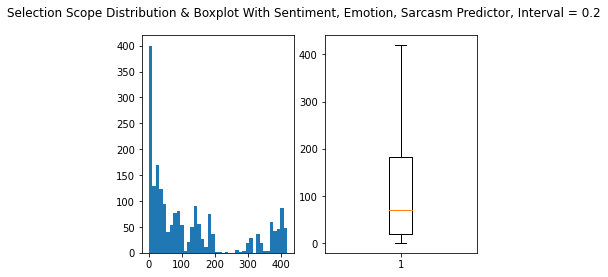

In [ ]:
import matplotlib.pyplot as plt

print("testing accuracy: %f" % np.mean(accuracy))
print("testing selection ratio: %f" % np.mean(selection_ratio))

plt.subplot(1, 2, 1)
plt.suptitle('Selection Scope Distribution & Boxplot With Sentiment, Emotion, Sarcasm Predictor, Interval = 0.2')
plt.hist(scope, bins=40)

plt.subplot(1, 2, 2)
plt.boxplot(scope)

plt.show

<function matplotlib.pyplot.show>

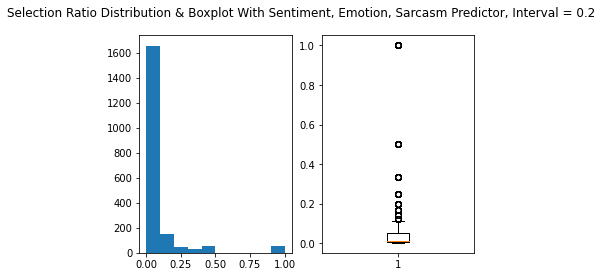

In [ ]:

plt.subplot(1, 2, 1)
plt.suptitle('Selection Ratio Distribution & Boxplot With Sentiment, Emotion, Sarcasm Predictor, Interval = 0.2')
plt.hist(selection_ratio)

plt.subplot(1, 2, 2)
plt.boxplot(selection_ratio)

plt.show

In [ ]:
accuracy_1 = []
scope_1 = []
selection_ratio_1 = []
for i in range(0,2000):
  x = df['text'][i]
  y_truth = df['0'][i]
  pred = suggest(x)
  accuracy_1.append(len(pred[pred['0'] == y_truth]))
  scope_1.append(len(pred))
  selection_ratio_1.append(len(pred[pred['0'] == y_truth])/len(pred))

testing accuracy: 1.013000
testing selection ratio: 0.056067


<function matplotlib.pyplot.show>

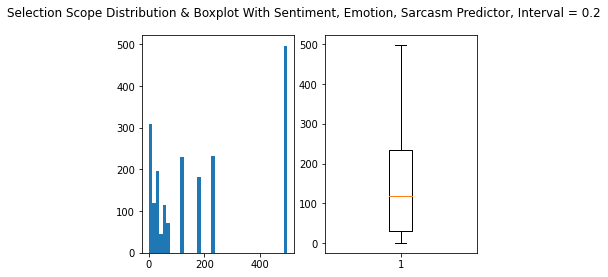

In [ ]:
print("testing accuracy: %f" % np.mean(accuracy_1))
print("testing selection ratio: %f" % np.mean(selection_ratio_1))

plt.subplot(1, 2, 1)
plt.suptitle('Selection Scope Distribution & Boxplot With Sentiment, Emotion, Sarcasm Predictor, Interval = 0.2')
plt.hist(scope_1, bins = 40)

plt.subplot(1, 2, 2)
plt.boxplot(scope_1)

plt.show

<function matplotlib.pyplot.show>

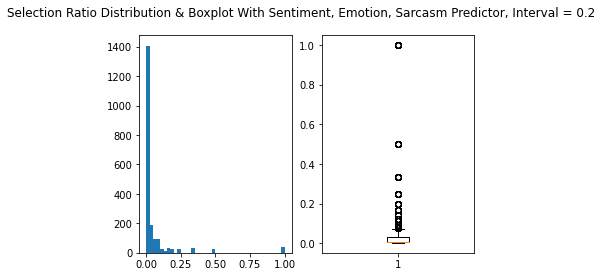

In [ ]:
plt.subplot(1, 2, 1)
plt.suptitle('Selection Ratio Distribution & Boxplot With Sentiment, Emotion, Sarcasm Predictor, Interval = 0.2')
plt.hist(selection_ratio_1, bins = 40)

plt.subplot(1, 2, 2)
plt.boxplot(selection_ratio_1)

plt.show